In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:


# %%capture
# !pip install opencv-python matplotlib imageio 
# !pip install tensorflow==2.10.0

In [1]:


import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2025-04-19 22:32:41.835839: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 22:32:41.836332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 22:32:41.838580: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-19 22:32:41.843946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745082161.853946   34396 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745082161.85

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU device not found
Found GPU at: 
GPU not available :(


E0000 00:00:1745082169.227901   34396 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745082169.228356   34396 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
E0000 00:00:1745082169.267869   34396 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745082169.267974   34396 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed prop

In [4]:
#This function loads a video from a given path and preprocesses the frames. The function returns a list of preprocessed frames.
def load_video(path:str) -> List[float]:

    # Open the video file
    cap = cv2.VideoCapture(path)

    # Initialize an empty list to store preprocessed frames
    frames = []

    # Iterate through each frame in the video
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        frame = tf.image.rgb_to_grayscale(frame)

        # Crop the frame to focus only on the lips and append the preprocessed frame to the list
        frames.append(frame[170:240,60:240,:])
    cap.release()

    # Calculate the mean and standard deviation of the frames
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Normalize the frames by subtracting the mean and dividing by the standard deviation
    return tf.cast((frames - mean), tf.float32) / std


In [5]:
lv= load_video('data/s1/Thumbs.db')

In [6]:


#list of major alphabets, numbers and special characters
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]



In [7]:


#Create a StringLookup layer to map characters to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
#Create a StringLookup layer to map integers back to characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)



The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [8]:


char_to_num(['s','k','a','t','y'])



<tf.Tensor: shape=(5,), dtype=int64, numpy=array([19, 11,  1, 20, 25])>

In [9]:

num_to_char([19, 11,  1, 20, 25])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b's', b'k', b'a', b't', b'y'], dtype=object)>

In [10]:
# Define a function to load alignments from a given path
def load_alignments(path:str) -> List[str]:
    # Open the file in read mode and get all the lines
    with open(path, 'r') as f:
        lines = f.readlines()

    # Initialize an empty list to hold the tokens
    tokens = []

    # Loop through each line in the file
    for line in lines:
        line = line.split() # Split the line into a list of words
        if line[2] != 'sil': # If the third word in the line is not 'sil'
            tokens = [*tokens,' ',line[2]] # Append a space and the third word to the tokens list

    # Split the tokens into individual characters, convert them to numerical values using char_to_num, and return the result
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str):
    try:
        # Decode path from bytes to string
        path = bytes.decode(path.numpy())
        file_name = path.split('/')[-1].split('.')[0]
        video_path = os.path.join('./data', 's1', f'{file_name}.mpg')
        alignment_path = os.path.join('./data', 'alignments', 's1', f'{file_name}.align')

        # Load video frames
        frames = load_video(video_path)
        if frames is None:
            raise ValueError(f"Video {video_path} is damaged or unreadable.")

        # Load alignments
        alignments = load_alignments(alignment_path)
        return frames, alignments
    except Exception as e:
        print(f"Skipping file {path} due to error: {e}")
        return None, None

In [12]:
test_path = './data/s1/bbal6n.mpg'

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

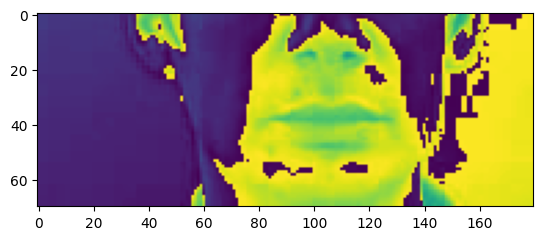

In [15]:
plt.imshow(frames[0])


In [16]:
print(alignments)

tf.Tensor([ 2  9 14 39  2 12 21  5 39  1 20 39 12 39 19  9 24 39 14 15 23], shape=(21,), dtype=int64)


In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]).numpy().decode('utf-8')

'bin blue at l six now'

In [18]:


def mappable_function(path:str) ->List[str]:
    # Call the load_data function using TensorFlow's py_function, which can be used to wrap Python functions
    # and make them usable inside a TensorFlow graph.
    # This allows us to load and preprocess data in parallel with TensorFlow's data pipeline.
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    # Return the loaded and preprocessed data
    return result


In [ ]:


# Get list of file paths for all videos
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# Shuffle the order of the videos
data = data.shuffle(497, reshuffle_each_iteration=False)
# Map the load_data function to each file path and get frames and alignments
data = data.map(mappable_function)
# Padded batch of 2 videos, with frames padded to 75 frames and alignments padded to 40 characters
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# Prefetch to optimize for performance
data = data.prefetch(tf.data.AUTOTUNE)
# Split the data into train and test sets
train = data.take(450)
test = data.skip(450)



In [20]:
print(len(train))
print(len(test))

450
47


In [21]:
len(frames)

75

In [22]:
sample = data.as_numpy_iterator()

In [23]:
val = sample.next(); val[0]
len(val)

2

In [24]:
# Normalize the frames to the range [0, 255] and convert to uint8
frames_to_save = (val[0][0]*255 ).astype(np.uint8)

# Save the frames as an animated GIF
imageio.mimsave('./animation.gif', [frame.squeeze() for frame in frames_to_save], fps=12)

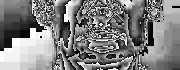

In [25]:
from IPython.display import Image, display

display(Image(filename="./animation.gif"))


In [26]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by u two now'>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [28]:
data.as_numpy_iterator().next()[0][0].shape

(75, 70, 180, 1)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPool3D, Activation, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, Lambda
import tensorflow as tf

model = Sequential()

# Add a Conv3D layer with 128 filters, kernel size of 3, and padding of 'same', with input shape of (75, 70, 180, 1)
model.add(Conv3D(128, 3, input_shape=(75, 70, 180, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Add another Conv3D layer with 256 filters, kernel size of 3, and padding of 'same'
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Add another Conv3D layer with 75 filters, kernel size of 3, and padding of 'same'
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

# Optionally print the shape after Conv3D layers (for debugging)
# model.add(Lambda(lambda x: print(x.shape)))

# Add a TimeDistributed layer with Flatten
model.add(TimeDistributed(Reshape((-1,))))

# Optionally print the shape after TimeDistributed(Flatten) (for debugging)
# model.add(Lambda(lambda x: print(x.shape)))

# Add a Bidirectional LSTM layer with 128 units, orthogonal kernel initializer, and return_sequences=True
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Add another Bidirectional LSTM layer with 128 units, orthogonal kernel initializer, and return_sequences=True
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

# Use a He normal initializer and softmax activation for the final dense layer
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))




/home/prince/Desktop/DL Project/Amit DL/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 70, 180,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 70, 180,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 35, 90,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 35, 90,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 35, 90,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 17, 45,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 17, 45, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 17, 45, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 8, 22, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 13200)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │    13,648,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,460,724 (58.98 MB)

 Trainable params: 15,460,724 (58.98 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:


yhat = model.predict(val[0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [32]:


tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])



<tf.Tensor: shape=(), dtype=string, numpy=b'222222222222222222222222222222222222222222222222222222222222222222222222222'>

In [33]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'222222222222222222222222222222222222222222222222222222222222222222222222222'>

In [34]:


#This function defines a learning rate scheduler that decays the learning rate exponentially
#after the 30th epoch. The scheduler function takes the epoch number and the current learning rate
#as inputs and returns the new learning rate to be used for the next epoch.

def scheduler(epoch, lr):
    if epoch < 1:
        return float(lr)  # Ensure the return value is a float
    else:
        return float(lr * tf.math.exp(-0.1))  # Convert the result to a float



In [35]:
#This function computes the Connectionist Temporal Classification (CTC) loss between the predicted labels and true labels.
#It takes two inputs, y_true and y_pred, which are the true and predicted labels respectively.

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:

class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        # Predict the output for the current batch using the model
        yhat = self.model.predict(data[0])
        # Decode the predicted output using CTC decoding
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        # Iterate over each item in the batch
        print('---------------------------------------------------------------')
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('---------------------------------------------------------------')
        print('---'*50)    


In [37]:


#The following code compiles the model with the Adam optimizer and sets the learning rate to 0.0001.
#It also sets the loss function to CTCLoss.
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)



In [38]:
from pathlib import Path
Path('./model').mkdir(parents=True, exist_ok=True)

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Ensure the directory exists for saving model checkpoints
os.makedirs('models', exist_ok=True)

# Setup checkpoint callback to save the best weights based on loss
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',            # Monitor training loss (use 'val_loss' for validation loss)
    save_weights_only=True,    # Save only the weights, not the full model
    save_best_only=True,       # Save the best model weights based on monitored metric
    save_freq='epoch'          # Save after every epoch
)


In [40]:


schedule_callback = LearningRateScheduler(scheduler)



In [41]:
example_callback = ProduceExample(test)

In [ ]:
# # Load the saved weights
# model.load_weights('models/checkpoint.weights.h5')

# # Fit the model again
# model.fit(
#     train,                             # Training data
#     validation_data=test,              # Validation data
#     callbacks=[schedule_callback, example_callback, checkpoint_callback],  # Callbacks
#     epochs=25                       # Number of epochs
# )

Epoch 1/25


/home/ravindra/miniconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1744965953.772916 1881817 service.cc:152] XLA service 0x7f7960003060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744965953.772938 1881817 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1744965954.655020 1881817 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


339/450 ━━━━━━━━━━━━━━━━━━━━ 52s 477ms/step - loss: 8.9057

[mpeg1video @ 0x7f778c033e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f778c033e80] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 8.8940

[mpeg1video @ 0x7f75b40085c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f75b40085c0] Warning MVs not available
[mpeg1video @ 0x7f7884004e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f7884004e00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
Original: place sp blue with x zero now
Prediction: place b blue with zero now
----------------------------------------------------------------------------------------------------
Original: bin red at m four please
Prediction: bin red at for please
----------------------------------------------------------------------------------------------------
450/450 ━━━━━━━━━━━━━━━━━━━━ 768s 2s/step - loss: 8.8937 - val_loss: 5.8421 - learning_rate: 1.0000e-04
Epoch 2/25
444/450 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - loss: 8.4749

[mpeg1video @ 0x7f763402d100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f763402d100] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 8.4768

[mpeg1video @ 0x7f7678005700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f7678005700] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Original: set green in b eight now
Prediction: set gren in b eight now
----------------------------------------------------------------------------------------------------
Original: lay blue at d eight please
Prediction: lay blue at eight please
----------------------------------------------------------------------------------------------------
450/450 ━━━━━━━━━━━━━━━━━━━━ 487s 1s/step - loss: 8.4771 - val_loss: 5.1254 - learning_rate: 9.0484e-05
Epoch 3/25
217/450 ━━━━━━━━━━━━━━━━━━━━ 1:50 475ms/step - loss: 8.2786

[mpeg1video @ 0x7f76a004c840] ac-tex damaged at 22 17
[mpeg1video @ 0x7f76a004c840] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 8.0992

[mpeg1video @ 0x7f7780034780] ac-tex damaged at 22 17
[mpeg1video @ 0x7f7780034780] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Original: bin white with u zero now
Prediction: bin white with u zoro now
----------------------------------------------------------------------------------------------------
Original: set white by v five again
Prediction: set white by v fivev again
----------------------------------------------------------------------------------------------------
450/450 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - loss: 8.0987 - val_loss: 4.4996 - learning_rate: 8.1873e-05
Epoch 4/25
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 7.3253

[mpeg1video @ 0x7f75f4034b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f75f4034b40] Warning MVs not available
[mpeg1video @ 0x7f76340239c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f76340239c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Original: set blue with u five soon
Prediction: set blue with u five son
----------------------------------------------------------------------------------------------------
Original: place green at e one again
Prediction: place gren at one again
----------------------------------------------------------------------------------------------------
450/450 ━━━━━━━━━━━━━━━━━━━━ 483s 1s/step - loss: 7.3256 - val_loss: 3.9815 - learning_rate: 7.4082e-05
Epoch 5/25
408/450 ━━━━━━━━━━━━━━━━━━━━ 19s 471ms/step - loss: 7.4811

[mpeg1video @ 0x7f775c005880] ac-tex damaged at 22 17
[mpeg1video @ 0x7f775c005880] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 7.4704Skipping file ./data/s1/bgit5s.mpg due to error: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Expected begin, end, and strides to be 1D equal size tensors, but got shapes [27,1], [3], and [3] instead. [Op:StridedSlice] name: strided_slice/
Skipping file ./data/s1/pgby5s.mpg due to error: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


2025-04-18 09:26:01.920017: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Expected begin, end, and strides to be 1D equal size tensors, but got shapes [27,1], [3], and [3] instead.
2025-04-18 09:26:01.920046: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Expected begin, end, and strides to be 1D equal size tensors, but got shapes [27,1], [3], and [3] instead.
2025-04-18 09:26:01.921117: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.
2025-04-18 09:26:01.921125: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.
2025-04-18 09:26:01.925257: W tensorflow/core/framework/op_kernel.cc:1844] INVALID_ARGUMENT: ValueError: Attempt to convert a value (N

InvalidArgumentError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:3 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Traceback (most recent call last):

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 162, in _call
    _maybe_copy_to_context_device(self._convert(x, dtype=dtype),
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 129, in _convert
    return ops.convert_to_tensor(value, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py", line 736, in convert_to_tensor
    return tensor_conversion_registry.convert(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 234, in convert
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_tensor_conversion.py", line 29, in _constant_tensor_conversion_function
    return constant_op.constant(v, dtype=dtype, name=name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/weak_tensor_ops.py", line 142, in wrapper
    return op(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 276, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 289, in _constant_impl
    return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 301, in _constant_eager_impl
    t = convert_to_eager_tensor(value, ctx, dtype)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 108, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to MapDataset:3 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Traceback (most recent call last):

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 162, in _call
    _maybe_copy_to_context_device(self._convert(x, dtype=dtype),
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 129, in _convert
    return ops.convert_to_tensor(value, dtype=dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/profiler/trace.py", line 183, in wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/ops.py", line 736, in convert_to_tensor
    return tensor_conversion_registry.convert(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/tensor_conversion_registry.py", line 234, in convert
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_tensor_conversion.py", line 29, in _constant_tensor_conversion_function
    return constant_op.constant(v, dtype=dtype, name=name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/ops/weak_tensor_ops.py", line 142, in wrapper
    return op(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 276, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 289, in _constant_impl
    return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 301, in _constant_eager_impl
    t = convert_to_eager_tensor(value, ctx, dtype)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/ravindra/miniconda3/lib/python3.12/site-packages/tensorflow/python/framework/constant_op.py", line 108, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_1511432]

[mpeg1video @ 0x7f76d402dc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f76d402dc40] Warning MVs not available


In [60]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

# Compile the model with the same optimizer
model.compile(loss=CTCLoss, optimizer=optimizer)

# Load the saved weights
model.load_weights('models/checkpoint.weights.h5')


/home/prince/Desktop/DL Project/Amit DL/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [61]:
# model.load_weights('models/checkpoint.weights.h5')


In [62]:
test_data = test.as_numpy_iterator()


In [63]:
sample = test_data.next()

[mpeg1video @ 0x7188b8007240] ac-tex damaged at 22 17
[mpeg1video @ 0x7188b8007240] Warning MVs not available


In [71]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [72]:
# Original Text
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by s seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y three soon'>]

In [73]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [74]:
#Predicted words
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by s seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by y three soon'>]